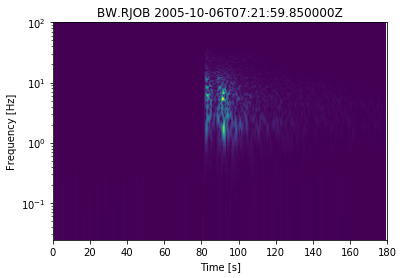

[None]

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

t1 = UTCDateTime("2010-09-3T16:30:00.000")
t2 = UTCDateTime("2010-09-3T17:00:00.000")
fdsn_client = Client('IRIS')
# Fetch waveform from IRIS FDSN web service into a ObsPy stream object
# and automatically attach correct response
st = fdsn_client.get_waveforms(network='NZ', station='BFZ', location='10',
                               channel='HHZ', starttime=t1, endtime=t2,
                               attach_response=True)
# define a filter band to prevent amplifying noise during the deconvolution
pre_filt = (0.005, 0.006, 30.0, 35.0)
st.remove_response(output='DISP', pre_filt=pre_filt)

1 Trace(s) in Stream:
NZ.BFZ.10.HHZ | 2010-09-03T16:30:00.008393Z - 2010-09-03T16:59:59.998393Z | 100.0 Hz, 180000 samples

In [3]:
from obspy import read, read_inventory

# simply use the included example waveform
st = read()
# the corresponding response is included in ObsPy as a StationXML file
inv = read_inventory()
# the routine automatically picks the correct response for each trace
# define a filter band to prevent amplifying noise during the deconvolution
pre_filt = (0.005, 0.006, 30.0, 35.0)
st.remove_response(inventory=inv, output='DISP', pre_filt=pre_filt)

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

In [4]:
from obspy import read, read_inventory

st = read("/path/to/IU_ULN_00_LH1_2015-07-18T02.mseed")
tr = st[0]
inv = read_inventory("/path/to/IU_ULN_00_LH1.xml")
pre_filt = [0.001, 0.005, 10, 20]
tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                   water_level=60, plot=True)

IU.ULN.00.LH1 | 2015-07-18T02:27:33.069538Z - 2015-07-18T05:27:32.069538Z | 1.0 Hz, 10800 samples

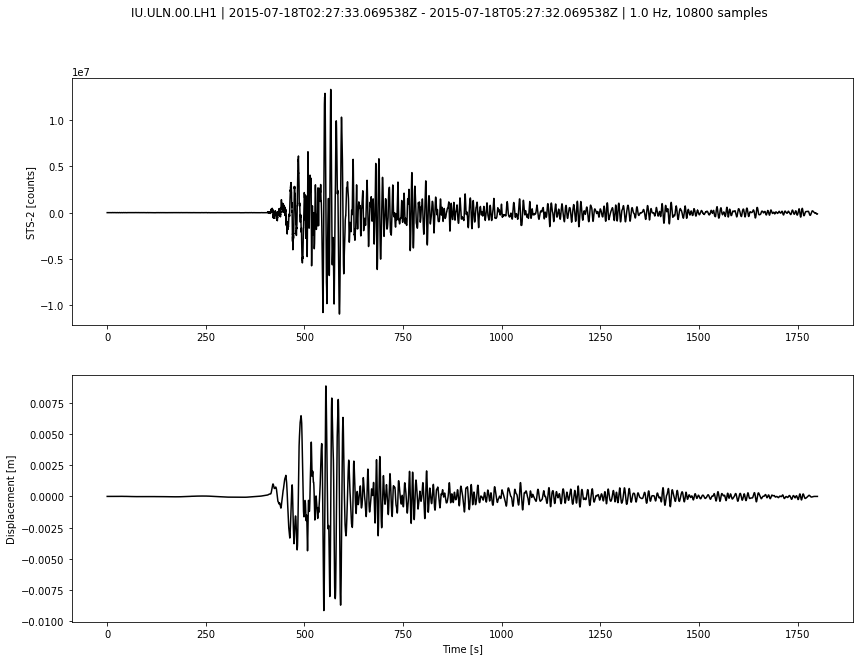

In [5]:
import matplotlib.pyplot as plt

import obspy
from obspy.core.util import NamedTemporaryFile
from obspy.clients.fdsn import Client as FDSN_Client
from obspy.clients.iris import Client as OldIris_Client


# MW 7.1 Darfield earthquake, New Zealand
t1 = obspy.UTCDateTime("2010-09-3T16:30:00.000")
t2 = obspy.UTCDateTime("2010-09-3T17:00:00.000")

# Fetch waveform from IRIS FDSN web service into a ObsPy stream object
fdsn_client = FDSN_Client("IRIS")
st = fdsn_client.get_waveforms('NZ', 'BFZ', '10', 'HHZ', t1, t2)

# Download and save instrument response file into a temporary file
with NamedTemporaryFile() as tf:
    respf = tf.name
    old_iris_client = OldIris_Client()
    # fetch RESP information from "old" IRIS web service, see obspy.fdsn
    # for accessing the new IRIS FDSN web services
    old_iris_client.resp('NZ', 'BFZ', '10', 'HHZ', t1, t2, filename=respf)

    # make a copy to keep our original data
    st_orig = st.copy()

    # define a filter band to prevent amplifying noise during the deconvolution
    pre_filt = (0.005, 0.006, 30.0, 35.0)

    # this can be the date of your raw data or any date for which the
    # SEED RESP-file is valid
    date = t1

    seedresp = {'filename': respf,  # RESP filename
                # when using Trace/Stream.simulate() the "date" parameter can
                # also be omitted, and the starttime of the trace is then used.
                'date': date,
                # Units to return response in ('DIS', 'VEL' or ACC)
                'units': 'DIS'
                }

    # Remove instrument response using the information from the given RESP file
    st.simulate(paz_remove=None, pre_filt=pre_filt, seedresp=seedresp)

# plot original and simulated data
tr = st[0]
tr_orig = st_orig[0]
time = tr.times()

plt.subplot(211)
plt.plot(time, tr_orig.data, 'k')
plt.ylabel('STS-2 [counts]')
plt.subplot(212)
plt.plot(time, tr.data, 'k')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')
plt.show()

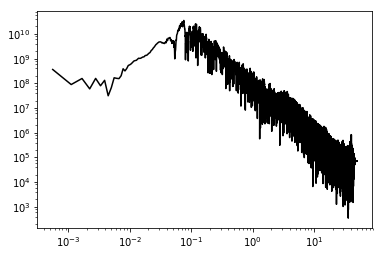

In [20]:
import numpy as np
from numpy import float64
from obspy import signal

xF = np.fft.fft(tr_orig.data)
N = len(xF)
xF = xF[0:N/2]
freq_axis = np.linspace(0,tr_orig.stats.sampling_rate/2,N/2)
frequency_spectra=abs(xF)
freq_axis = float64(freq_axis)
frequency_spectra = float64(frequency_spectra)
plt.loglog(freq_axis, frequency_spectra, 'k')
plt.show()

In [ ]:
frequency_spectra_smooth = signal.konnoohmachismoothing.konno_ohmachi_smoothing(frequency_spectra, freq_axis, bandwidth=100, max_memory_usage=1024, normalize=True)
plt.loglog(frequency_spectra_smooth, 'k')
plt.show()

In [ ]:
smoothed_1